In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import bootstrap
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:
- ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
- ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
- ab_products – подробная информация о продуктах, их название и стоимость

In [2]:
users = pd.read_csv('ab_users_data.csv')
products = pd.read_csv('ab_products.csv')
orders = pd.read_csv('ab_orders.csv')

In [3]:
#Знакомство с нашими данными: кол-во строк и столбцов, типы переменных, а так же наличие пропущенных значений

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


In [4]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [6]:
users.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [7]:
products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [8]:
orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [9]:
# Преобразуем столбцы с датами в формат datetime
users[['time', 'date']] = users[['time', 'date']].apply(pd.to_datetime)
orders['creation_time'] = orders['creation_time'].apply(pd.to_datetime)

In [10]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [11]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [12]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


In [23]:
users.action.value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

**Первая гипотеза для проверки:**
- **Нулевая гипотеза (H0):** Средний чек пользователей в тестовой и контрольной группах не имеет значительных различий.
- **Альтернативная гипотеза (H1):** Средний чек пользователей в тестовой и контрольной группах имеет значительные различия.

In [24]:
# Посчитаем и сравним средний чек в наших группах

In [25]:
# Преобразуем column 'product_ids' в список и расширим DataFrame
orders['product_ids'] = orders['product_ids'].str.strip('{}').str.split(', ')
df_exploded = orders.explode('product_ids')

In [26]:
df_exploded = df_exploded.rename(columns={'product_ids': 'product_id'})

In [27]:
# Изменим тип данных в столбце product_id
df_exploded['product_id'] = df_exploded['product_id'].astype(int)

In [28]:
df_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13826 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       13826 non-null  int64         
 1   creation_time  13826 non-null  datetime64[ns]
 2   product_id     13826 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 432.1 KB


In [29]:
# Объединим наш датафрейм с датафремом с товарами products
orders_with_products = pd.merge(df_exploded, products, on='product_id')

In [30]:
orders_with_products.head()

,order_id,creation_time,product_id,name,price
0,1255,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,1287,2022-08-26 00:31:36,75,сок ананасовый,120.0
2,1403,2022-08-26 03:01:40,75,сок ананасовый,120.0
3,1424,2022-08-26 04:01:22,75,сок ананасовый,120.0
4,1495,2022-08-26 06:04:05,75,сок ананасовый,120.0


In [31]:
# Объединим получившийся датафрейм с датафремом с пользователями users
orders_with_products_and_users = pd.merge(orders_with_products, users, on='order_id')

In [32]:
orders_with_products_and_users.head()

,order_id,creation_time,product_id,name,price,user_id,action,time,date,group
0,1255,2022-08-26 00:00:19,75,сок ананасовый,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0
1,1255,2022-08-26 00:00:19,22,сок мультифрукт,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0
2,1255,2022-08-26 00:00:19,53,мука,78.3,964,create_order,2022-08-26 00:00:19,2022-08-26,0
3,1255,2022-08-26 00:00:19,84,мандарины,90.4,964,create_order,2022-08-26 00:00:19,2022-08-26,0
4,1287,2022-08-26 00:31:36,75,сок ананасовый,120.0,987,create_order,2022-08-26 00:31:36,2022-08-26,0


In [33]:
# Уберем отмененные заказы и посчитаем сумму каждого заказа
total_order_values = orders_with_products_and_users.query('action == "create_order"').groupby(['user_id', 'group', 'order_id'], as_index=False)['price'].sum()
total_order_values

,user_id,group,order_id,price
0,964,0,1255,408.7
1,964,0,1257,310.2
2,965,1,1256,250.5
3,965,1,3946,860.6
4,965,1,9097,608.2
...,...,...,...,...
4118,1980,1,57384,259.9
4119,1980,1,57498,239.0
4120,1980,1,58430,892.7
4121,1980,1,58460,203.2


In [34]:
# Посчитаем средний чек для каждого пользователя
user_avg_check = total_order_values.groupby(['user_id', 'group'], as_index=False)['price'].mean()
user_avg_check

,user_id,group,price
0,964,0,359.450000
1,965,1,461.722222
2,966,0,85.000000
3,967,1,227.480000
4,968,0,530.233333
...,...,...,...
1012,1976,1,400.380000
1013,1977,1,195.300000
1014,1978,1,395.228571
1015,1979,1,391.483333


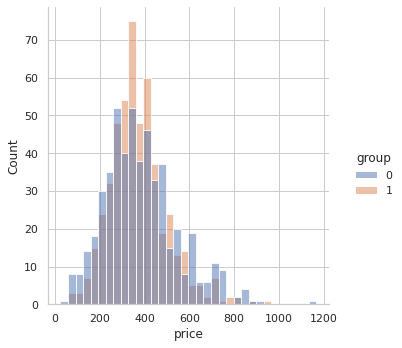

In [35]:
# Построим гистограмму 
sns.displot(data=user_avg_check, x="price", hue="group")

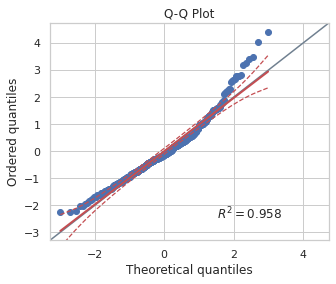

In [36]:
pg.qqplot(user_avg_check.query('group==1').price)

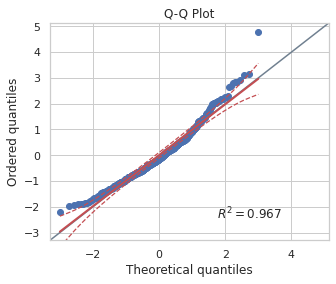

In [37]:
pg.qqplot(user_avg_check.query('group==0').price)

In [39]:
# Мы видим, что распределение стремится к нормальному.

# Тест Левене для проверки гомогенности дисперсий
levene_test_avg_check = stats.levene(user_avg_check.query('group==1').price, user_avg_check.query('group==0').price)

print("Levene's test p-value:", levene_test_avg_check.pvalue)

Levene's test p-value: 4.6983734882388866e-07


In [40]:
# В зависимости от результата теста Левене
if levene_test_avg_check.pvalue > 0.05:
    # Если p-value больше 0.05, мы принимаем гипотезу о равенстве дисперсий
    t_stat, p_value = stats.ttest_ind(user_avg_check.query('group==1').price, user_avg_check.query('group==0').price, equal_var=True)
else:
    # Если p-value меньше 0.05, дисперсии разные
    t_stat, p_value = stats.ttest_ind(user_avg_check.query('group==1').price, user_avg_check.query('group==0').price, equal_var=False)
    
print("P-value:", p_value)

P-value: 0.2516901316467041


In [40]:
# p-значение > 0.05 
# Это указывает на то, что нет статистически значимого различия между средними чеками в группах 
# с новой системой рекомендаций и без нее.

In [41]:
# Помимо среднего чека мы можем сравнить количество заказов в наших группах

**Вторая гипотеза для проверки:**
- **Нулевая гипотеза (H0):** Среднее число заказов пользователей в тестовой и контрольной группах не имеет значительных различий.
- **Альтернативная гипотеза (H1):** Среднее число заказов пользователей в тестовой и контрольной группах имеет значительные различия.

In [42]:
# Вернемся к датафрейму, в котором хранится суммка для каждого неотмененного заказа
total_order_values.head()

,user_id,group,order_id,price
0,964,0,1255,408.7
1,964,0,1257,310.2
2,965,1,1256,250.5
3,965,1,3946,860.6
4,965,1,9097,608.2


In [43]:
quantity_df = total_order_values.groupby(['user_id', 'group'], as_index=False).agg({'order_id':'count'}).rename(columns={'order_id': 'order_quantity'})

In [44]:
quantity_df

,user_id,group,order_quantity
0,964,0,2
1,965,1,9
2,966,0,1
3,967,1,5
4,968,0,3
...,...,...,...
1012,1976,1,5
1013,1977,1,4
1014,1978,1,7
1015,1979,1,6


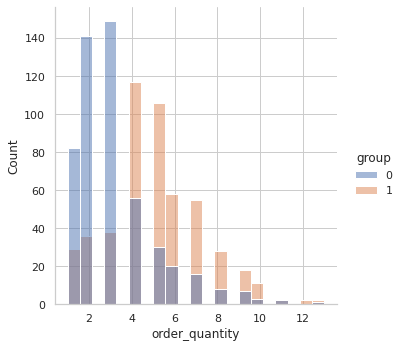

In [45]:
# Построим гистограмму 
sns.displot(data=quantity_df, x="order_quantity", hue="group")

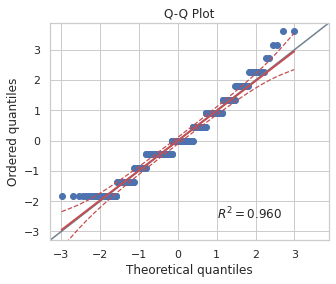

In [46]:
pg.qqplot(quantity_df.query('group==1').order_quantity)

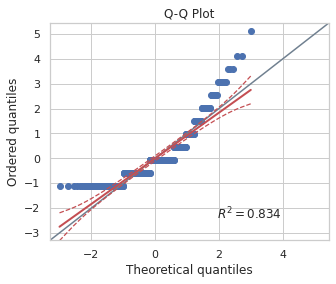

In [47]:
pg.qqplot(quantity_df.query('group==0').order_quantity)

In [48]:
quantity_df.groupby("group").order_quantity.std()

group
0    1.922651
1    2.210467
Name: order_quantity, dtype: float64

In [49]:
# Тест Левене для проверки гомогенности дисперсий
levene_test_quantity = stats.levene(quantity_df.query("group == 1").order_quantity, quantity_df.query("group == 0").order_quantity)

print("Levene's test p-value:", levene_test_quantity.pvalue)

Levene's test p-value: 6.226688002409379e-05


In [50]:
# В зависимости от результата теста Левене
if levene_test_quantity.pvalue > 0.05:
    # Если p-value больше 0.05, мы принимаем гипотезу о равенстве дисперсий
    t_stat, p_value = stats.ttest_ind(quantity_df.query("group == 1").order_quantity, quantity_df.query("group == 0").order_quantity, equal_var=True)
else:
    # Если p-value меньше 0.05, дисперсии разные
    t_stat, p_value = stats.ttest_ind(quantity_df.query("group == 1").order_quantity, quantity_df.query("group == 0").order_quantity, equal_var=False)
    
print("P-value:", p_value)

P-value: 2.9077831935473898e-43


In [52]:
# Количество заказов существенно выше для группы с новой системой рекомендаций

In [53]:
mean_test = quantity_df.query("group == 1").order_quantity.mean()
mean_control = quantity_df.query("group == 0").order_quantity.mean()

In [54]:
mean_test / mean_control

1.6029232974874894

**Вывод**: В ходе проведения АБ-теста и статистического анализа метрик были получены следующие результаты: средний чек остался практически без изменений. Это указывает на то, что внедрение новой системы рекомендаций для всех пользователей может быть нецелесообразным.
Тем не менее, новая система рекомендаций значительно (в 1,6 раза) увеличила количество заказов на пользователя, что свидетельствует о том, что она стимулирует существующих клиентов заказывать чаще. Это может способствовать формированию устойчивой клиентской базы в будущем. Увеличение числа заказов может компенсировать отсутствие роста среднего чека.
Таким образом, новая система рекомендаций принесла пользу как бизнесу, так и пользователям приложения, так как пользователи стали чаще совершать заказы, что, в свою очередь, увеличивает прибыль компании. Поэтому стоит рассмотреть возможность распространения этой системы на всех пользователей.